# The iterative model experiment

1. Use the filtering and cleansing method already in place to create dataset
2. Split the dataset into two subsets, denoted as Train1 and Train2. Use Train1 to build a model.
3. With the model, output predictions and the confidence on Train2 (confidence is the probability associated with the decoder output). Samples with the confidence higher than a threshold will be selected as the filtered Train2 dataset.
4. Using the filtered Train2 dataset to train another model.
5. With the model, output predictions and the confidence on Train1 (confidence is the probability associated with the decoder output). Samples with the confidence higher than a threshold will be selected as the filtered Train1 dataset.
6. Iterate the above process multiple steps to get the final round of filtered Train1 and Train2. Then merge them to train a model and evaluate on the test dataset.

In [74]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9472801180384835037
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9146282803
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1021914811730012969
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1"
]


In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [4]:
import sys
sys.path.insert(0,'F:\\')

In [6]:
language = 'ja'
import name_transliteration.filtering as filter
import name_transliteration.cleansing as cleanse
import name_transliteration.model_trainer_and_tester as model_trainer_and_tester

In [7]:
# filter testing and training data
my_filter = filter.Filter(language)
my_filter.filterData("./data/")

# split filtered data into two sets
filtered_set_A = my_filter.getDataFrame().iloc[:int(len(my_filter.getDataFrame())/2)]
filtered_set_B = my_filter.getDataFrame().iloc[int(len(my_filter.getDataFrame())/2):]

./data/stream-2021-03-07T030507.831679.gz
./data/stream-2021-01-13T012129.804195.gz
./data/stream-2021-01-13T040746.253913.gz
./data/stream-2021-01-12T230830.828340.gz
./data/stream-2021-01-13T033820.383129.gz
./data/stream-2021-03-07T063003.830030.gz
./data/stream-2021-01-13T043735.200990.gz
./data/stream-2021-03-07T033453.811604.gz
./data/stream-2021-04-17T072341.809159.gz
./data/stream-2021-01-12T223933.810384.gz
./data/stream-2021-03-06T032542.946878.gz
./data/stream-2021-01-12T220926.798946.gz
./data/stream-2021-03-07T040604.938654.gz
./data/stream-2021-03-07T013945.126113.gz
./data/stream-2021-03-07T083055.833881.gz
./data/stream-2021-03-07T023622.842559.gz
./data/stream-2021-03-06T013350.975776.gz
./data/stream-2021-03-06T015957.825571.gz
./data/stream-2021-03-07T075003.791977.gz
./data/stream-2021-04-17T044934.818794.gz
./data/stream-2021-03-06T003821.058969.gz
./data/stream-2021-03-07T012937.938029.gz
./data/stream-2021-01-13T00022

In [54]:
# instantiate the cleanser
my_cleanser = cleanse.Cleanser()

# perform pre-processing on set A and B and save
filtered_set_B["username"] = filtered_set_B["username"].apply(my_cleanser.transformUserName)
filtered_set_B = filtered_set_B[['username','screen_name']]
filtered_set_B.to_csv('filtered_set_B.txt', header=None, index=None, sep='\t', mode='w')

filtered_set_A["username"] = filtered_set_A["username"].apply(my_cleanser.transformUserName)
filtered_set_A = filtered_set_A[['username','screen_name']]
filtered_set_A.to_csv('filtered_set_A.txt', header=None, index=None, sep='\t', mode='w')

In [9]:
# define variables

edit_threshold = 0.1
edit_string = str(int(edit_threshold*100))
model_name = 'model_1'

In [10]:

# the split data is uncleansed btw
my_cleanser.splitTrainTest(filtered_set_A)

# this does the cleansing of the test datasets
my_cleanser.createTestDataSets()
# this does the cleansing of the training dataset
my_cleanser.createTrainDataSet(edit_threshold = edit_threshold)
# save cleansed test and train files
my_cleanser.saveTestAndTrain()

Saved cleansed names as: 
train_10_edit_distance_language_cleansed.txt 11993 number of rows. 
test1_cleansed.txt 174 number of rows. 
test2_cleansed.txt 234 number of rows. 
test3_cleansed.txt 481 number of rows. 



In [11]:
# train model and save model 1
model_1 = model_trainer_and_tester.ModelTrainerAndTester(
    language=language, 
    epochs=10
)
model_1.determineDimensions(['train_'+edit_string+'_edit_distance_language_cleansed.txt', 'test1_cleansed.txt', 'test2_cleansed.txt', 'test3_cleansed.txt', 'filtered_set_B.txt'])
train_encode_input, train_decode_input, train_decode_output = model_1.processData('train_'+edit_string+'_edit_distance_language_cleansed.txt')
model_1.buildModel()
model_1.trainModel(model_name, train_encode_input, train_decode_input, train_decode_output)
model_1.createDecoderEncoder(model_name)

Number of unique input tokens: 27
Number of unique output tokens: 5051
Max sequence length for inputs: 22
Max sequence length for outputs: 52
<class 'tensorflow.python.keras.engine.functional.Functional'>
Epoch 1/10
300/300 [==============================] - 73s 217ms/step - loss: 0.5731 - accuracy: 0.9129 - val_loss: 0.4143 - val_accuracy: 0.9272
Epoch 2/10
300/300 [==============================] - 59s 198ms/step - loss: 0.3981 - accuracy: 0.9284 - val_loss: 0.3795 - val_accuracy: 0.9295
Epoch 3/10
300/300 [==============================] - 51s 170ms/step - loss: 0.3699 - accuracy: 0.9314 - val_loss: 0.3585 - val_accuracy: 0.9321
Epoch 4/10
300/300 [==============================] - 64s 214ms/step - loss: 0.3465 - accuracy: 0.9337 - val_loss: 0.3345 - val_accuracy: 0.9346
Epoch 5/10
300/300 [==============================] - 50s 166ms/step - loss: 0.3276 - accuracy: 0.9359 - val_loss: 0.3262 - val_accuracy: 0.9366
Epoch 6/10
300/300 [==============================] - 46s 152ms/step -

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


In [12]:
model_1.evaluateOnTestData(model_name)


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 1s 32ms/step - loss: 0.1868 - accuracy: 0.9618
test loss, test acc: [0.18678702414035797, 0.9617595076560974]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 0s 29ms/step - loss: 0.2331 - accuracy: 0.9551
test loss, test acc: [0.23313584923744202, 0.9551281929016113]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 1s 30ms/step - loss: 0.2933 - accuracy: 0.9449
test loss, test acc: [0.29326751828193665, 0.9448664784431458]


# Reloading model 1 since it has already been trained on previous runs

In [13]:
language = 'ja'
import name_transliteration.model_trainer_and_tester as model_trainer_and_tester
import numpy as np
import matplotlib.pyplot as plt

In [14]:
loaded_model = model_trainer_and_tester.ModelTrainerAndTester(
    language=language
)
loaded_model.loadDataParameters()
loaded_model.createDecoderEncoder('model_1')

In [15]:
loaded_model.evaluateOnTestData('model_1')


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 3s 29ms/step - loss: 0.1868 - accuracy: 0.9618
test loss, test acc: [0.18678702414035797, 0.9617595076560974]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 0s 26ms/step - loss: 0.2331 - accuracy: 0.9551
test loss, test acc: [0.23313584923744202, 0.9551281929016113]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 1s 30ms/step - loss: 0.2933 - accuracy: 0.9449
test loss, test acc: [0.29326751828193665, 0.9448664784431458]


In [21]:
# the create_probabilities() method is really memory intensive
# it crashes when trying to predict files with over 20,000 rows
# to solve this issue, we are going to split a large file into multiple ones each with only 20,000 rows

lines_per_file = 20000
smallfile = None
total_lines = 0
with open('filtered_set_B.txt',encoding='utf-8') as bigfile:
    for line_number, line in enumerate(bigfile):
        if line_number % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = 'filtered_set_B_{}.txt'.format(int(line_number/lines_per_file))
            smallfile = open(small_filename, "w", encoding='utf-8')
        smallfile.write(line)
        total_lines = total_lines + 1
    if smallfile:
        smallfile.close()

In [22]:
total_runs = int(total_lines/20000)+1

In [23]:
def return_prob_list(run_number):
    loaded_model = model_trainer_and_tester.ModelTrainerAndTester(
        language=language
    )
    loaded_model.loadDataParameters()
    loaded_model.createDecoderEncoder('model_1')
    prob_list = loaded_model.create_probabilities("filtered_set_B_{}.txt".format(run_number))
    del loaded_model
    return prob_list

In [24]:
big_prob_list = []
for i in range(total_runs):
    prob_list = return_prob_list(i)
    big_prob_list.extend(prob_list)
    del prob_list

data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
completed prediction iteration: 4 of 21
completed prediction iteration: 5 of 21
completed prediction iteration: 6 of 21
completed prediction iteration: 7 of 21
completed prediction iteration: 8 of 21
completed prediction iteration: 9 of 21
completed prediction iteration: 10 of 21
completed prediction iteration: 11 of 21
completed prediction iteration: 12 of 21
completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction iteration: 16 of 21
completed prediction iteration: 17 of 21
completed prediction iteration: 18 of 21
completed prediction iteration: 19 of 21
completed prediction iteration: 20 of 21
20000 predictions completed
data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
compl

completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction iteration: 16 of 21
completed prediction iteration: 17 of 21
completed prediction iteration: 18 of 21
completed prediction iteration: 19 of 21
completed prediction iteration: 20 of 21
20000 predictions completed
data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
completed prediction iteration: 4 of 21
completed prediction iteration: 5 of 21
completed prediction iteration: 6 of 21
completed prediction iteration: 7 of 21
completed prediction iteration: 8 of 21
completed prediction iteration: 9 of 21
completed prediction iteration: 10 of 21
completed prediction iteration: 11 of 21
completed prediction iteration: 12 of 21
completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction

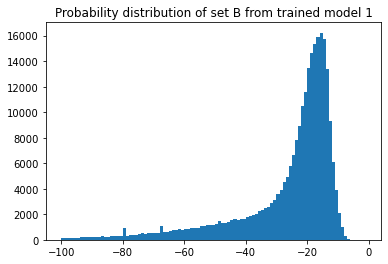

In [25]:
plt.hist(np.array(big_prob_list), bins=np.arange(100)-100)
plt.title('Probability distribution of set B from trained model 1')
plt.show()

In [26]:
min(big_prob_list)

-340.6515060757155

In [27]:
# save the probabability list to disk, takes a long time to generate
with open('set_B_prob_list_logged.txt', 'w') as f:
    for item in big_prob_list:
        f.write("%s\n" % item)

In [13]:
# reload the saved log probabilities
big_prob_list = []
with open('set_B_prob_list_logged.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        big_prob_list.append(float(line))

In [28]:
big_prob_list

[-14.271241248788106,
 -35.15907067498188,
 -37.434697493043345,
 -13.779404014630583,
 -13.851040999676854,
 -79.18710486950538,
 -24.578696966122195,
 -24.663664783667553,
 -11.801486316404617,
 -12.054685353530697,
 -68.25098516378124,
 -30.379266537225885,
 -18.44368733764285,
 -21.34259319674683,
 -43.069733616713776,
 -12.983928263226408,
 -14.859443418366508,
 -16.590922766739506,
 -15.927110847510736,
 -31.939949680888592,
 -61.333148306013115,
 -16.437891948305275,
 -20.40837970092757,
 -14.920440925281653,
 -66.44372386416154,
 -18.33821270465197,
 -10.769966326300745,
 -34.72722105504847,
 -9.495355418472307,
 -19.257530644691776,
 -18.344613739056545,
 -21.41273522409812,
 -15.67484018644935,
 -21.959916065491107,
 -31.367619071308503,
 -18.451252368748484,
 -15.652943573735929,
 -19.22487108044193,
 -16.642624562629745,
 -12.02757892097742,
 -18.24676834703367,
 -25.11989152467509,
 -19.137915086067355,
 -13.554220687056231,
 -15.518657641232274,
 -14.217912563713638,
 -20

In [37]:
probability_threshold = -12
drop_list = []
for i, prob in enumerate(big_prob_list):
    if prob <= probability_threshold:
        drop_list.append(i)

In [38]:
len(big_prob_list)-len(drop_list)

13462

In [39]:
len(big_prob_list)

265298

In [40]:
# reload filtered_set_B
import pandas as pd
filtered_set_B = pd.read_csv('filtered_set_B.txt', header=None, sep='\t')
filtered_set_B.columns = ['username', 'screen_name']

In [41]:
cleansed_set_B = filtered_set_B.drop(drop_list)

In [42]:
cleansed_set_B

,username,screen_name
8,asahimaru,あさひ
26,oto saikyo,おと
28,daiki asuka,大輝
68,mugen byakuya,白夜
116,aaaaa,柏
...,...,...
265133,nakigitune,零
265137,tuki tesan,月
265200,ay tqv oee lkzn m,なな
265295,mjtrognmgm,あ


In [43]:
cleansed_set_B = cleansed_set_B[['username','screen_name']]

In [44]:
cleansed_set_B.to_csv('cleansed_set_B_logged.txt', header=None, index=None, sep='\t', mode='w')

In [45]:
# training model 2
model_B = model_trainer_and_tester.ModelTrainerAndTester(
    language=language, 
    epochs=10
)
model_B.loadDataParameters()
train_encode_input, train_decode_input, train_decode_output = model_B.processData('cleansed_set_B_logged.txt')
model_B.buildModel()
model_B.trainModel('model_2', train_encode_input, train_decode_input, train_decode_output)
model_B.createDecoderEncoder('model_2')

<class 'tensorflow.python.keras.engine.functional.Functional'>
Epoch 1/10
337/337 [==============================] - 85s 245ms/step - loss: 0.3439 - accuracy: 0.9603 - val_loss: 0.2165 - val_accuracy: 0.9699
Epoch 2/10
337/337 [==============================] - 64s 191ms/step - loss: 0.2088 - accuracy: 0.9702 - val_loss: 0.2069 - val_accuracy: 0.9709
Epoch 3/10
337/337 [==============================] - 49s 145ms/step - loss: 0.1999 - accuracy: 0.9709 - val_loss: 0.1995 - val_accuracy: 0.9712
Epoch 4/10
337/337 [==============================] - 57s 170ms/step - loss: 0.1973 - accuracy: 0.9710 - val_loss: 0.1962 - val_accuracy: 0.9717
Epoch 5/10
337/337 [==============================] - 40s 119ms/step - loss: 0.1926 - accuracy: 0.9715 - val_loss: 0.1999 - val_accuracy: 0.9715
Epoch 6/10
337/337 [==============================] - 71s 212ms/step - loss: 0.1909 - accuracy: 0.9716 - val_loss: 0.1928 - val_accuracy: 0.9720
Epoch 7/10
337/337 [==============================] - 60s 179ms/ste

INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


In [46]:
model_B.evaluateOnTestData('model_2')


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 1s 29ms/step - loss: 0.4103 - accuracy: 0.9399
test loss, test acc: [0.4102736711502075, 0.9398761987686157]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 0s 29ms/step - loss: 0.4724 - accuracy: 0.9348
test loss, test acc: [0.47243374586105347, 0.93482905626297]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 1s 30ms/step - loss: 0.5390 - accuracy: 0.9298
test loss, test acc: [0.5390446782112122, 0.9298336505889893]


# Now we perform another cleanse using trained model, this time on set A

In [55]:
language = 'ja'
import name_transliteration.model_trainer_and_tester as model_trainer_and_tester
import numpy as np
import matplotlib.pyplot as plt

In [56]:
loaded_model = model_trainer_and_tester.ModelTrainerAndTester(
    language=language
)
loaded_model.loadDataParameters()
loaded_model.createDecoderEncoder('model_2')

In [57]:
loaded_model.evaluateOnTestData('model_2')


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 1s 29ms/step - loss: 0.4103 - accuracy: 0.9399
test loss, test acc: [0.4102736711502075, 0.9398761987686157]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 0s 30ms/step - loss: 0.4724 - accuracy: 0.9348
test loss, test acc: [0.47243374586105347, 0.93482905626297]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 1s 35ms/step - loss: 0.5390 - accuracy: 0.9298
test loss, test acc: [0.5390446782112122, 0.9298336505889893]


In [58]:
# the create_probabilities() method is really memory intensive
# it crashes when trying to predict files with over 20,000 rows
# to solve this issue, we are going to split a large file into multiple ones each with only 20,000 rows

lines_per_file = 20000
smallfile = None
total_lines = 0
with open('filtered_set_A.txt',encoding='utf-8') as bigfile:
    for line_number, line in enumerate(bigfile):
        if line_number % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = 'filtered_set_A_{}.txt'.format(int(line_number/lines_per_file))
            smallfile = open(small_filename, "w", encoding='utf-8')
        smallfile.write(line)
        total_lines = total_lines + 1
    if smallfile:
        smallfile.close()

In [59]:
total_runs = int(total_lines/20000)+1

In [60]:
# redefine this function, this time with model_2
def return_prob_list(run_number):
    loaded_model = model_trainer_and_tester.ModelTrainerAndTester(
        language=language
    )
    loaded_model.loadDataParameters()
    loaded_model.createDecoderEncoder('model_2')
    prob_list = loaded_model.create_probabilities("filtered_set_A_{}.txt".format(run_number))
    del loaded_model
    return prob_list

In [61]:
big_prob_list = []
for i in range(total_runs):
    prob_list = return_prob_list(i)
    big_prob_list.extend(prob_list)
    del prob_list

data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
completed prediction iteration: 4 of 21
completed prediction iteration: 5 of 21
completed prediction iteration: 6 of 21
completed prediction iteration: 7 of 21
completed prediction iteration: 8 of 21
completed prediction iteration: 9 of 21
completed prediction iteration: 10 of 21
completed prediction iteration: 11 of 21
completed prediction iteration: 12 of 21
completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction iteration: 16 of 21
completed prediction iteration: 17 of 21
completed prediction iteration: 18 of 21
completed prediction iteration: 19 of 21
completed prediction iteration: 20 of 21
20000 predictions completed
data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
compl

completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction iteration: 16 of 21
completed prediction iteration: 17 of 21
completed prediction iteration: 18 of 21
completed prediction iteration: 19 of 21
completed prediction iteration: 20 of 21
20000 predictions completed
data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
completed prediction iteration: 4 of 21
completed prediction iteration: 5 of 21
completed prediction iteration: 6 of 21
completed prediction iteration: 7 of 21
completed prediction iteration: 8 of 21
completed prediction iteration: 9 of 21
completed prediction iteration: 10 of 21
completed prediction iteration: 11 of 21
completed prediction iteration: 12 of 21
completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction

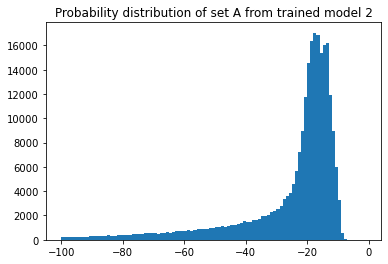

In [62]:
plt.hist(np.array(big_prob_list), bins=np.arange(100)-100)
plt.title('Probability distribution of set A from trained model 2')
plt.show()

In [63]:
# save the probabability list to disk, takes a long time to generate
with open('set_A_prob_list_logged.txt', 'w') as f:
    for item in big_prob_list:
        f.write("%s\n" % item)

In [67]:
probability_threshold = -11.5
drop_list = []
for i, prob in enumerate(big_prob_list):
    if prob <= probability_threshold:
        drop_list.append(i)
len(big_prob_list)-len(drop_list)

14067

In [68]:
# reload filtered_set_A
import pandas as pd
filtered_set_A = pd.read_csv('filtered_set_A.txt', header=None, sep='\t')
filtered_set_A.columns = ['username', 'screen_name']

In [69]:
cleansed_set_A = filtered_set_A.drop(drop_list)

In [70]:
cleansed_set_A = cleansed_set_A[['username','screen_name']]

In [71]:
cleansed_set_A.to_csv('cleansed_set_A_logged.txt', header=None, index=None, sep='\t', mode='w')

In [72]:
# training model 3
model_C = model_trainer_and_tester.ModelTrainerAndTester(
    language=language, 
    epochs=10
)
model_C.loadDataParameters()
train_encode_input, train_decode_input, train_decode_output = model_C.processData('cleansed_set_A_logged.txt')
model_C.buildModel()
model_C.trainModel('model_3', train_encode_input, train_decode_input, train_decode_output)
model_C.createDecoderEncoder('model_3')

<class 'tensorflow.python.keras.engine.functional.Functional'>
Epoch 1/10
352/352 [==============================] - 92s 253ms/step - loss: 0.3124 - accuracy: 0.9633 - val_loss: 0.1855 - val_accuracy: 0.9720
Epoch 2/10
352/352 [==============================] - 55s 155ms/step - loss: 0.1817 - accuracy: 0.9720 - val_loss: 0.1759 - val_accuracy: 0.9725
Epoch 3/10
352/352 [==============================] - 61s 172ms/step - loss: 0.1727 - accuracy: 0.9727 - val_loss: 0.1732 - val_accuracy: 0.9732
Epoch 4/10
352/352 [==============================] - 61s 174ms/step - loss: 0.1654 - accuracy: 0.9736 - val_loss: 0.1666 - val_accuracy: 0.9737
Epoch 5/10
352/352 [==============================] - 64s 181ms/step - loss: 0.1610 - accuracy: 0.9741 - val_loss: 0.1644 - val_accuracy: 0.9739
Epoch 6/10
352/352 [==============================] - 50s 143ms/step - loss: 0.1577 - accuracy: 0.9745 - val_loss: 0.1599 - val_accuracy: 0.9748
Epoch 7/10
352/352 [==============================] - 62s 178ms/ste

INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


In [73]:
model_C.evaluateOnTestData('model_3')


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 1s 31ms/step - loss: 0.6053 - accuracy: 0.9398
test loss, test acc: [0.6052640676498413, 0.9397656917572021]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 0s 28ms/step - loss: 0.6986 - accuracy: 0.9347
test loss, test acc: [0.6985589861869812, 0.9346646666526794]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 1s 30ms/step - loss: 0.7921 - accuracy: 0.9294
test loss, test acc: [0.7921251654624939, 0.9294338822364807]


In [2]:
prob_list = []

loaded_model.create_probabilities("filtered_set_B_small.txt")

data is processed
completed prediction iteration: 1 of 21
completed prediction iteration: 2 of 21
completed prediction iteration: 3 of 21
completed prediction iteration: 4 of 21
completed prediction iteration: 5 of 21
completed prediction iteration: 6 of 21
completed prediction iteration: 7 of 21
completed prediction iteration: 8 of 21
completed prediction iteration: 9 of 21
completed prediction iteration: 10 of 21
completed prediction iteration: 11 of 21
completed prediction iteration: 12 of 21
completed prediction iteration: 13 of 21
completed prediction iteration: 14 of 21
completed prediction iteration: 15 of 21
completed prediction iteration: 16 of 21
completed prediction iteration: 17 of 21
completed prediction iteration: 18 of 21
completed prediction iteration: 19 of 21
completed prediction iteration: 20 of 21
20000 predictions completed
CPU times: user 10min 48s, sys: 2min 45s, total: 13min 34s
Wall time: 3min 30s


In [7]:
import pandas as pd
filtered_set_B_small = pd.read_csv("filtered_set_B_small.txt", sep='\t', header=None)

In [25]:
probability_threshold = 0.75
drop_list = []
for i, prob in enumerate(prob_list):
    if prob <= probability_threshold:
        drop_list.append(i)

In [26]:
len(drop_list)

19968

In [27]:
cleansed_set_B_small = filtered_set_B_small.drop(drop_list)

In [28]:
cleansed_set_B_small.to_csv('cleansed_set_B_small.txt', header=None, index=None, sep='\t', mode='w')

In [29]:
# training model B
model_B = model_trainer_and_tester.ModelTrainerAndTester(
    language=language, 
    epochs=10
)
model_B.loadDataParameters()
train_encode_input, train_decode_input, train_decode_output = model_B.processData('cleansed_set_B_small.txt')
model_B.buildModel()
model_B.trainModel('model_B', train_encode_input, train_decode_input, train_decode_output)
model_B.createDecoderEncoder('model_B')

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 8.5300 - accuracy: 0.0000e+00 - val_loss: 8.4246 - val_accuracy: 0.9478
Epoch 2/10
1/1 [==============================] - 1s 843ms/step - loss: 8.4261 - accuracy: 0.9362 - val_loss: 7.2243 - val_accuracy: 0.9478
Epoch 3/10
1/1 [==============================] - 1s 752ms/step - loss: 7.2259 - accuracy: 0.9362 - val_loss: 4.7276 - val_accuracy: 0.9478
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 4.7397 - accuracy: 0.9362 - val_loss: 3.0267 - val_accuracy: 0.9478
Epoch 5/10
1/1 [==============================] - 1s 814ms/step - loss: 3.0447 - accuracy: 0.9362 - val_loss: 1.7828 - val_accuracy: 0.9478
Epoch 6/10
1/1 [==============================] - 1s 790ms/step - loss: 1.8037 - accuracy: 0.9362 - val_loss: 1.0615 - val_accuracy: 0.9478
Epoch 7/10
1/1 [==============================] - 1s 751ms/step - loss: 1.0894 - accuracy: 0.9362 - val_loss: 0.7252 - val_accuracy: 0.9478
Epoch 8/10
1/1 [======

INFO:tensorflow:Assets written to: model_B/assets


INFO:tensorflow:Assets written to: model_B/assets


In [30]:
model_B.evaluateOnTestData('model_B')


evaluating on test set with 0 edit threshold...
6/6 [==============================] - 2s 211ms/step - loss: 0.6919 - accuracy: 0.9164
test loss, test acc: [0.6918842792510986, 0.9164456129074097]
evaluating on test set with 0.1 edit threshold...
8/8 [==============================] - 2s 213ms/step - loss: 0.7414 - accuracy: 0.9113
test loss, test acc: [0.7413906455039978, 0.9113247990608215]
evaluating on test set with 0.25 edit threshold...
16/16 [==============================] - 4s 237ms/step - loss: 0.7879 - accuracy: 0.9071
test loss, test acc: [0.7879423499107361, 0.9071245789527893]


# I have forgotten what everything below is supposed to do

In [10]:
prob_list = trainer_and_tester.create_probabilities('small_names.txt')

finished predictions!


In [17]:
import numpy as np
def create_probabilities(data_path):
    test_encoder_input, test_decoder_input, test_decoder_output = trainer_and_tester.processData(data_path)
    prediction = trainer_and_tester.model.predict([test_encoder_input, test_decoder_input])
    print("finished predictions!")

    # prediction is a three dimensional numpy array
    # first dimension relatees to which row of the original data
    # second dimension is the sequence dimension, length will be the max decoder length
    # third dimension is a probability distribution, length will be the number of target tokens
    prob_list = []
    for row in prediction:
        for time_step in row:
            highest_prob_idx = np.argmax(time_step[:])
            if trainer_and_tester.reverse_target_char_index[highest_prob_idx] == '\n':
                prob = max(time_step[:])
                prob_list.append(prob)
                break
    return prob_list

In [23]:
prob_list = create_probabilities('small_names.txt')

finished predictions!


In [24]:
prob_list

[0.17142753,
 0.05898299,
 0.27404648,
 0.24443997,
 0.8746748,
 0.08803612,
 0.59971315,
 0.15099098,
 0.36538252,
 0.29847044,
 0.020500638,
 0.39464876,
 0.092565365,
 0.19886206,
 0.08433535,
 0.3660765,
 0.40596545,
 0.037862115,
 0.09895991,
 0.5024829,
 0.12542808]

In [27]:
trainer_and_tester.predict('amaimono no')

('まままま\n', 0.24569076)

In [11]:
trainer_and_tester.reverse_target_char_index[6]

'\n'

In [15]:
# train model 2 and save model 2
trainer_and_tester2 = model_trainer_and_tester.ModelTrainerAndTester(
    language=language, 
    epochs=20
)
# trainer_and_tester2.determineDimensions(['train_10_edit_distance_language_cleansed.txt', 'test1_cleansed.txt', 'test2_cleansed.txt', 'test3_cleansed.txt', 'filtered_set_B.txt','model_cleansed_names.txt'])
# train_encode_input, train_decode_input, train_decode_output = trainer_and_tester2.processData('model_cleansed_names.txt')
# trainer_and_tester2.buildModel()
# trainer_and_tester2.trainModel(language + '_model_'+str(20)+'_v2', train_encode_input, train_decode_input, train_decode_output)
# trainer_and_tester2.createDecoderEncoder(language + '_model_'+str(20)+'_v2')

trainer_and_tester2.runWholeTrainProcess('model_cleansed_names.txt', 'model_20_v2')

Number of unique input tokens: 27
Number of unique output tokens: 937
Max sequence length for inputs: 19
Max sequence length for outputs: 43
Epoch 1/20
21/21 [==============================] - 6s 182ms/step - loss: 3.2954 - accuracy: 0.7149 - val_loss: 0.8984 - val_accuracy: 0.8613
Epoch 2/20
21/21 [==============================] - 3s 149ms/step - loss: 0.9094 - accuracy: 0.8595 - val_loss: 0.8778 - val_accuracy: 0.8625
Epoch 3/20
21/21 [==============================] - 4s 169ms/step - loss: 0.8777 - accuracy: 0.8636 - val_loss: 0.9020 - val_accuracy: 0.8635
Epoch 4/20
21/21 [==============================] - 3s 165ms/step - loss: 0.8133 - accuracy: 0.8684 - val_loss: 0.8771 - val_accuracy: 0.8633
Epoch 5/20
21/21 [==============================] - 4s 191ms/step - loss: 0.8245 - accuracy: 0.8665 - val_loss: 0.8873 - val_accuracy: 0.8640
Epoch 6/20
21/21 [==============================] - 3s 166ms/step - loss: 0.8412 - accuracy: 0.8631 - val_loss: 0.8771 - val_accuracy: 0.8633
Epoch 7

INFO:tensorflow:Assets written to: ja_model_20_v2/assets


In [16]:
trainer_and_tester2.evaluateOnTestData('model_'+str(20)+'_v2')


evaluating on test set with 0 edit threshold...
5/5 [==============================] - 1s 51ms/step - loss: 0.4885 - accuracy: 0.9236
test loss, test acc: [0.4885435402393341, 0.9235658645629883]
evaluating on test set with 0.1 edit threshold...
7/7 [==============================] - 0s 57ms/step - loss: 0.5423 - accuracy: 0.9160
test loss, test acc: [0.5423395037651062, 0.91595458984375]
evaluating on test set with 0.25 edit threshold...
14/14 [==============================] - 1s 52ms/step - loss: 0.5509 - accuracy: 0.9147
test loss, test acc: [0.5509322285652161, 0.9147106409072876]


In [17]:
print(trainer_and_tester.predict('reiwatomo'))
print(trainer_and_tester2.predict('reiwatomo'))

('あくち\n', 0.22617334)
('お\n', 0.0751004)


In [18]:
training_set_A = my_cleanser.training_dataframe

In [22]:
training_set_A

,index,username,screen_name,language
0,10,amaimono no,甘いもの,ja
1,33,animejikkyobot,アニメ実況,ja
2,42,tsudayan,つだやん,ja
3,47,ayu ko,鮎子,ja
4,63,mashiroharu,ましろはる,ja
...,...,...,...,...
2295,25766,future,ふつれ,ja
2296,25786,ri o,りお,ja
2297,25791,future,ふつれ,ja
2298,25804,paprikasan,パプリカ,ja


In [24]:
trainer_and_tester2.predict('zigo aku')

('お\n', 0.07910247)

In [21]:
training_set_A["conf"] = training_set_A["username"].apply(predict_confidence, args=(trainer_and_tester2,))

KeyboardInterrupt: 

In [19]:
test_encoder_input, test_decoder_input, test_decoder_output = loaded_model.processData('small_names.txt')

In [22]:
prediction = loaded_model.model.predict([test_encoder_input, test_decoder_input])

In [42]:
prediction[0,6,loaded_model.target_token_index['\n']]

1.0649676e-06

In [101]:
trainer_and_tester.predict("oharafumi")

('あくち\n', 0.16680214)

In [111]:
trainer_and_tester.reverse_target_char_index[0]

' '

In [113]:
prob_list = []
for i in range(len(prediction)):
    char_idx = np.argmax(prediction[i,0,:])
    print(char_idx)
#     j = 1
#     while char_idx != 0:
#         char_idx = np.argmax(prediction[i,j,:])
#         print(char_idx)
    

42
42
42
42
42
42
42


In [79]:
prediction[0,5,0]

0.9899092

In [64]:
prediction

array([[[8.3742070e-06, 1.4098549e-06, 6.5861754e-03, ...,
         1.3929487e-06, 1.3458267e-06, 1.3111600e-06],
        [3.7974369e-04, 8.7453395e-07, 1.7892161e-02, ...,
         9.0219305e-07, 9.1668733e-07, 8.6946778e-07],
        [2.0483108e-03, 5.9531010e-07, 1.1048008e-02, ...,
         6.6449655e-07, 6.2310545e-07, 5.8859285e-07],
        ...,
        [9.9999952e-01, 3.4604161e-13, 2.7603728e-10, ...,
         3.6542796e-13, 3.3970927e-13, 3.3975074e-13],
        [9.9999952e-01, 3.4598550e-13, 2.7601357e-10, ...,
         3.6530045e-13, 3.3962506e-13, 3.3969501e-13],
        [9.9999952e-01, 3.4592481e-13, 2.7598673e-10, ...,
         3.6517507e-13, 3.3954084e-13, 3.3963864e-13]],

       [[2.5005045e-03, 2.6287576e-06, 3.9306772e-03, ...,
         2.6972739e-06, 2.8987240e-06, 2.6490445e-06],
        [2.5983499e-02, 9.0083904e-07, 4.4184611e-03, ...,
         7.9166932e-07, 9.6195356e-07, 8.6236685e-07],
        [1.4645259e-01, 3.5979941e-08, 3.9797407e-04, ...,
         3.750

In [69]:
trainer_and_tester.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 27)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 2972)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 290816      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  3306496     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [ ]:
# also generate prediction and use edit distance to compare against